# Preprocessing the Reddit Comments Dataset for Time Series Analysis

Supplementary notebook for Utkarsh and Soham's ASDS 5306 Course Project

In [1]:
import kagglehub
from spacy.lang.en import English
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textstat

# kagglehub.login()

In [2]:
import matplotlib.font_manager as fm

path_to_public_sans = fm.findfont('Public Sans')
public_sans = fm.FontProperties(fname=path_to_public_sans)

sns.set_style("whitegrid")
plt.rcParams['font.family'] = public_sans.get_name()  # Register the font by its internal name
plt.rcParams['font.size'] = 12

# set figure size to 14, 6 in rcparams
plt.rcParams['figure.figsize'] = 14, 6
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.facecolor'] = '#f7f6f2'
plt.rcParams['axes.facecolor'] = '#f7f6f2'
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.55
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#095859"])

# xtick text size
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [3]:
# initializing the English model for SpaCy
nlp = English()

In [4]:
# Download and init the latest version of the comments dataset
path = kagglehub.dataset_download("tushar5harma/topredditcomments")

In [5]:
top_posts = pd.read_csv(path + "/Top_Posts.csv")
top_posts.head()

post_id                                         post_title        subreddit  \
0  gh1dj9  [Project] From books to presentations in 10s w...  MachineLearning   
1  kuc6tz  [D] A Demo from 1993 of 32-year-old Yann LeCun...  MachineLearning   
2  g7nfvb  [R] First Order Motion Model applied to animat...  MachineLearning   
3  lui92h  [N] AI can turn old photos into moving Images ...  MachineLearning   
4  ohxnts  [D] This AI reveals how much time politicians ...  MachineLearning   

                              post_url  flair_text  score  comments  \
0      https://v.redd.it/v492uoheuxx41     Project   7798       186   
1      https://v.redd.it/25nxi9ojfha61  Discussion   5851       133   
2      https://v.redd.it/rlmmjm1q5wu41    Research   4761       111   
3      https://v.redd.it/ikd5gjlbi8k61        News   4688       230   
4  https://i.redd.it/34sgziebfia71.jpg  Discussion   4568       228   

   upvote_ratio            date-time  year  
0          0.99  2020-05-10 13:19:54  2020  
1          0.98  2021-01-10 10:30:36  2021  
2          0.97  2020-04-25 04:27:23  2020  
3          0.97  2021-02-28 15:12:28  2021  
4          0.96  2021-07-11 04:18:59  2021

In [6]:
comments = pd.read_csv(path + "/Top_Posts_Comments.csv")
comments.head()

post_id                                            comment
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...
1  gh1dj9                                       The future 🤯
2  gh1dj9  Simple yet very useful. Thank you for sharing ...
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...
4  gh1dj9  Ohh the nightmare of making this into a stable...

Sometimes comments on Reddit can be deleted, which reflects in the content as the string, `[deleted]`, and such rows must be deleted from our dataset

In [13]:
comments = comments.drop(comments[comments['comment'] == '[deleted]'].index)
comments.size

431260

Additionally, some comments in the dataset are null values, and we can drop such comments from consideration.

In [14]:
comments = comments.dropna(subset=['comment'])

In [15]:
comments.head()

post_id                                            comment
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...
1  gh1dj9                                       The future 🤯
2  gh1dj9  Simple yet very useful. Thank you for sharing ...
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...
4  gh1dj9  Ohh the nightmare of making this into a stable...

Additionally, it might be a good idea to clean the Markdown formatting that Reddit allows, which may interfere with our analysis in the coming steps. To do so, we can use the `clean_markdown_ function as defined below:

In [16]:
import re

def clean_markdown(text):
    # Remove Markdown links [text](url)
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    # Remove inline formatting like *italic*, **bold**, ***bold italic***
    text = re.sub(r'(\*+)(\w+?)\1', r'\2', text)
    # Remove strikethrough ~~text~~
    text = re.sub(r'~~(.*?)~~', r'\1', text)
    # Remove blockquotes > text
    text = re.sub(r'^>\s+', '', text, flags=re.MULTILINE)
    # Remove inline code `code` and code blocks ```code```
    text = re.sub(r'`([^`]*)`', r'\1', text)
    # Remove any remaining Markdown syntax (fallback)
    text = re.sub(r'[_*~`]', '', text)
    # Remove emails
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # replace `\n` with a full-stop and space
    text = text.replace('\n', '. ')
    return text

In [17]:
comments['cleaned_comment'] = comments['comment'].apply(clean_markdown)

In [18]:
comments.head()

post_id                                            comment  \
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...   
1  gh1dj9                                       The future 🤯   
2  gh1dj9  Simple yet very useful. Thank you for sharing ...   
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...   
4  gh1dj9  Ohh the nightmare of making this into a stable...   

                                     cleaned_comment  
0  Twitter thread: . . Code: . . Background remov...  
1                                       The future 🤯  
2  Simple yet very useful. Thank you for sharing ...  
3  Almost guaranteed, Apple will copy your idea i...  
4  Ohh the nightmare of making this into a stable...

Now that all null values and deleted comments are excluded, we can calculate comment lengths by number of words. 

In [19]:
comments['length'] = comments['comment'].str.split(' ').apply(len)
comments.head()

post_id                                            comment  \
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...   
1  gh1dj9                                       The future 🤯   
2  gh1dj9  Simple yet very useful. Thank you for sharing ...   
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...   
4  gh1dj9  Ohh the nightmare of making this into a stable...   

                                     cleaned_comment  length  
0  Twitter thread: . . Code: . . Background remov...      35  
1                                       The future 🤯       3  
2  Simple yet very useful. Thank you for sharing ...      10  
3  Almost guaranteed, Apple will copy your idea i...      11  
4  Ohh the nightmare of making this into a stable...      19

In [20]:
comments.describe()

length
count  215614.000000
mean       46.168811
std        68.636365
min         1.000000
25%        10.000000
50%        25.000000
75%        55.000000
max      2208.000000

Now, let's consider another metric like the Type-Token Ratio, which is the ratio of _unique_ to _total_ words in some text. Higher TTR's may be indicative of richer, more diverse language that in turn signals more complex thought processes.

In [21]:
def type_token_ratio(text):
    # using the spacy tokenizer here may be helpful to obtain more accurate TTR's
    doc = nlp(text)
    tokens = [token.text for token in doc]
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

In [22]:
comments['ttr'] = comments['comment'].apply(type_token_ratio)
comments.head()

post_id                                            comment  \
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...   
1  gh1dj9                                       The future 🤯   
2  gh1dj9  Simple yet very useful. Thank you for sharing ...   
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...   
4  gh1dj9  Ohh the nightmare of making this into a stable...   

                                     cleaned_comment  length       ttr  
0  Twitter thread: . . Code: . . Background remov...      35  0.758065  
1                                       The future 🤯       3  1.000000  
2  Simple yet very useful. Thank you for sharing ...      10  0.916667  
3  Almost guaranteed, Apple will copy your idea i...      11  0.866667  
4  Ohh the nightmare of making this into a stable...      19  1.000000

The next metric we can consider for each comment is the Flesch-Kincaid Grade Level, a score that indicates the minimum grade level of education required to understand a given text. For reference, the U.S. Government uses a baseline of Grade 9 for most reference manuals and texts it produces.

In [23]:
def flesch_kincaid_grade_level(text):
    return textstat.flesch_kincaid_grade(text)

In [24]:
comments['fkgl'] = comments['comment'].apply(flesch_kincaid_grade_level)
comments.head()

post_id                                            comment  \
0  gh1dj9  Twitter thread: [https://twitter.com/cyrildiag...   
1  gh1dj9                                       The future 🤯   
2  gh1dj9  Simple yet very useful. Thank you for sharing ...   
3  gh1dj9  Almost guaranteed, Apple will copy your idea i...   
4  gh1dj9  Ohh the nightmare of making this into a stable...   

                                     cleaned_comment  length       ttr  fkgl  
0  Twitter thread: . . Code: . . Background remov...      35  0.758065  19.7  
1                                       The future 🤯       3  1.000000   2.9  
2  Simple yet very useful. Thank you for sharing ...      10  0.916667   1.7  
3  Almost guaranteed, Apple will copy your idea i...      11  0.866667   5.2  
4  Ohh the nightmare of making this into a stable...      19  1.000000   3.5

In [25]:
# comments longer than 150 words
long_comments = comments[(comments['length'].isin(range(150, 1000))) & (comments['fkgl'] > 0)]
long_comments.describe()

length           ttr          fkgl
count  11852.000000  11852.000000  11852.000000
mean     251.987681      0.559271     10.006969
std      119.986187      0.074717      4.650957
min      150.000000      0.019113      0.600000
25%      173.000000      0.517104      7.900000
50%      210.000000      0.569231      9.500000
75%      284.000000      0.612440     11.400000
max      996.000000      0.756098    173.700000

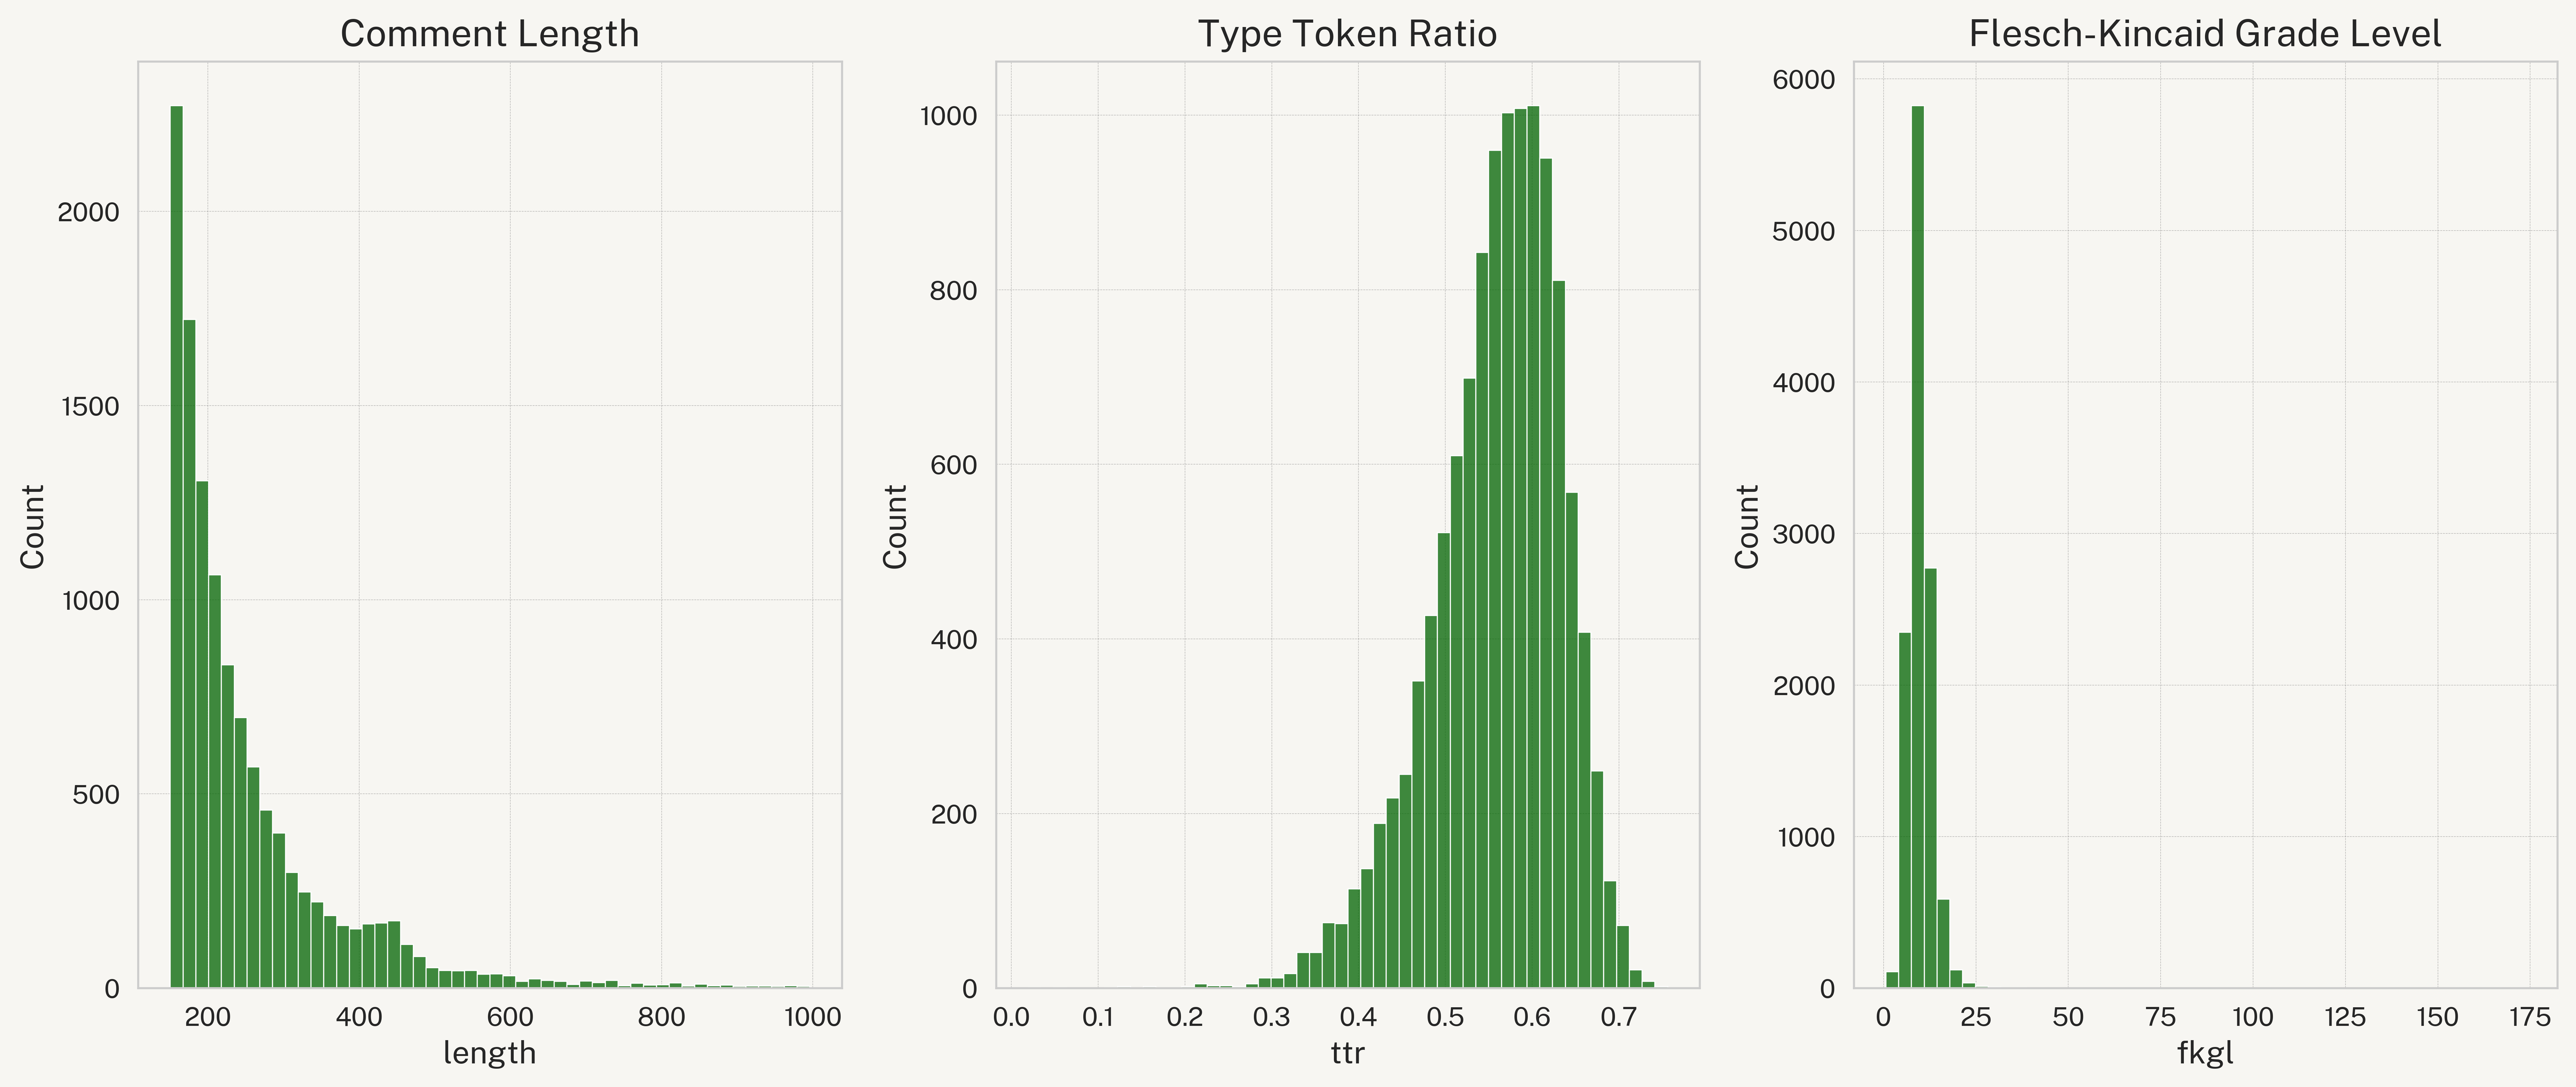

In [56]:
# plotting histograms for the length, TTR and FKGL

fig, axes = plt.subplots(1, 3)

sns.histplot(data=long_comments, x='length', bins=50, ax=axes[0], color='darkgreen')
axes[0].set_title('Comment Length')
sns.histplot(data=long_comments, x='ttr', bins=50, ax=axes[1], color='darkgreen')
axes[1].set_title('Type Token Ratio')
sns.histplot(data=long_comments, x='fkgl', bins=50, ax=axes[2], color='darkgreen')
axes[2].set_title('Flesch-Kincaid Grade Level')

plt.tight_layout()
plt.show() 

In preparation to merge comments into the posts dataframe, we need to aggregate metrics by each `post_id`. For example, let's consider the average.

In [27]:
# aggregate metrics for each post_id

post_metrics = long_comments.groupby('post_id').agg({ 'length': 'mean', 'ttr': 'mean', 'fkgl': 'mean' }).reset_index()
post_metrics.head()

post_id      length       ttr       fkgl
0  1008i6v  186.000000  0.401961  11.800000
1  101t0vt  168.000000  0.585799  19.500000
2  1027spa  211.500000  0.556451   6.733333
3  1032pgs  398.090909  0.530987  10.018182
4  1033ecx  161.000000  0.524064  19.500000

In [28]:
# merge post_metrics with top_posts

top_posts = top_posts.merge(post_metrics, on='post_id')
top_posts.head()

post_id                                         post_title        subreddit  \
0  gh1dj9  [Project] From books to presentations in 10s w...  MachineLearning   
1  kuc6tz  [D] A Demo from 1993 of 32-year-old Yann LeCun...  MachineLearning   
2  lui92h  [N] AI can turn old photos into moving Images ...  MachineLearning   
3  ohxnts  [D] This AI reveals how much time politicians ...  MachineLearning   
4  n2f0ld               [D] Types of Machine Learning Papers  MachineLearning   

                              post_url  flair_text  score  comments  \
0      https://v.redd.it/v492uoheuxx41     Project   7798       186   
1      https://v.redd.it/25nxi9ojfha61  Discussion   5851       133   
2      https://v.redd.it/ikd5gjlbi8k61        News   4688       230   
3  https://i.redd.it/34sgziebfia71.jpg  Discussion   4568       228   
4  https://i.redd.it/6z2s8h1iahw61.jpg  Discussion   4370       219   

   upvote_ratio            date-time  year  length       ttr       fkgl  
0          0.99  2020-05-10 13:19:54  2020   264.0  0.546962  12.433333  
1          0.98  2021-01-10 10:30:36  2021   221.5  0.527130   9.100000  
2          0.97  2021-02-28 15:12:28  2021   181.0  0.588785   9.200000  
3          0.96  2021-07-11 04:18:59  2021   250.0  0.581921  10.971429  
4          0.98  2021-05-01 09:32:20  2021   192.6  0.588889   7.740000

In [29]:
top_posts = top_posts.rename(columns={'length': 'avg_comment_length', 'ttr': 'avg_comment_ttr', 'fkgl': 'avg_comment_fkgl'})
top_posts.head()

post_id                                         post_title        subreddit  \
0  gh1dj9  [Project] From books to presentations in 10s w...  MachineLearning   
1  kuc6tz  [D] A Demo from 1993 of 32-year-old Yann LeCun...  MachineLearning   
2  lui92h  [N] AI can turn old photos into moving Images ...  MachineLearning   
3  ohxnts  [D] This AI reveals how much time politicians ...  MachineLearning   
4  n2f0ld               [D] Types of Machine Learning Papers  MachineLearning   

                              post_url  flair_text  score  comments  \
0      https://v.redd.it/v492uoheuxx41     Project   7798       186   
1      https://v.redd.it/25nxi9ojfha61  Discussion   5851       133   
2      https://v.redd.it/ikd5gjlbi8k61        News   4688       230   
3  https://i.redd.it/34sgziebfia71.jpg  Discussion   4568       228   
4  https://i.redd.it/6z2s8h1iahw61.jpg  Discussion   4370       219   

   upvote_ratio            date-time  year  avg_comment_length  \
0          0.99  2020-05-10 13:19:54  2020               264.0   
1          0.98  2021-01-10 10:30:36  2021               221.5   
2          0.97  2021-02-28 15:12:28  2021               181.0   
3          0.96  2021-07-11 04:18:59  2021               250.0   
4          0.98  2021-05-01 09:32:20  2021               192.6   

   avg_comment_ttr  avg_comment_fkgl  
0         0.546962         12.433333  
1         0.527130          9.100000  
2         0.588785          9.200000  
3         0.581921         10.971429  
4         0.588889          7.740000

## Generating weekly Time Series data for each post's comment length, ttr and fkgl

In [30]:
top_posts['date-time'] = pd.to_datetime(top_posts['date-time'])
top_posts.info()
# top_posts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   post_id             1734 non-null   object        
 1   post_title          1734 non-null   object        
 2   subreddit           1734 non-null   object        
 3   post_url            1734 non-null   object        
 4   flair_text          1481 non-null   object        
 5   score               1734 non-null   int64         
 6   comments            1734 non-null   int64         
 7   upvote_ratio        1734 non-null   float64       
 8   date-time           1734 non-null   datetime64[ns]
 9   year                1734 non-null   int64         
 10  avg_comment_length  1734 non-null   float64       
 11  avg_comment_ttr     1734 non-null   float64       
 12  avg_comment_fkgl    1734 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3), obje

In [31]:
top_posts['week'] = top_posts['date-time'].dt.isocalendar().week
top_posts.head()

post_id                                         post_title        subreddit  \
0  gh1dj9  [Project] From books to presentations in 10s w...  MachineLearning   
1  kuc6tz  [D] A Demo from 1993 of 32-year-old Yann LeCun...  MachineLearning   
2  lui92h  [N] AI can turn old photos into moving Images ...  MachineLearning   
3  ohxnts  [D] This AI reveals how much time politicians ...  MachineLearning   
4  n2f0ld               [D] Types of Machine Learning Papers  MachineLearning   

                              post_url  flair_text  score  comments  \
0      https://v.redd.it/v492uoheuxx41     Project   7798       186   
1      https://v.redd.it/25nxi9ojfha61  Discussion   5851       133   
2      https://v.redd.it/ikd5gjlbi8k61        News   4688       230   
3  https://i.redd.it/34sgziebfia71.jpg  Discussion   4568       228   
4  https://i.redd.it/6z2s8h1iahw61.jpg  Discussion   4370       219   

   upvote_ratio           date-time  year  avg_comment_length  \
0          0.99 2020-05-10 13:19:54  2020               264.0   
1          0.98 2021-01-10 10:30:36  2021               221.5   
2          0.97 2021-02-28 15:12:28  2021               181.0   
3          0.96 2021-07-11 04:18:59  2021               250.0   
4          0.98 2021-05-01 09:32:20  2021               192.6   

   avg_comment_ttr  avg_comment_fkgl  week  
0         0.546962         12.433333    19  
1         0.527130          9.100000     1  
2         0.588785          9.200000     8  
3         0.581921         10.971429    27  
4         0.588889          7.740000    17

In [32]:
# drop post_title, post_url, subreddit, flair_text, score, upvote_ratio
top_posts = top_posts.drop(columns=['post_title', 'post_url', 'subreddit', 'flair_text', 'score', 'upvote_ratio'])
top_posts.head()

post_id  comments           date-time  year  avg_comment_length  \
0  gh1dj9       186 2020-05-10 13:19:54  2020               264.0   
1  kuc6tz       133 2021-01-10 10:30:36  2021               221.5   
2  lui92h       230 2021-02-28 15:12:28  2021               181.0   
3  ohxnts       228 2021-07-11 04:18:59  2021               250.0   
4  n2f0ld       219 2021-05-01 09:32:20  2021               192.6   

   avg_comment_ttr  avg_comment_fkgl  week  
0         0.546962         12.433333    19  
1         0.527130          9.100000     1  
2         0.588785          9.200000     8  
3         0.581921         10.971429    27  
4         0.588889          7.740000    17

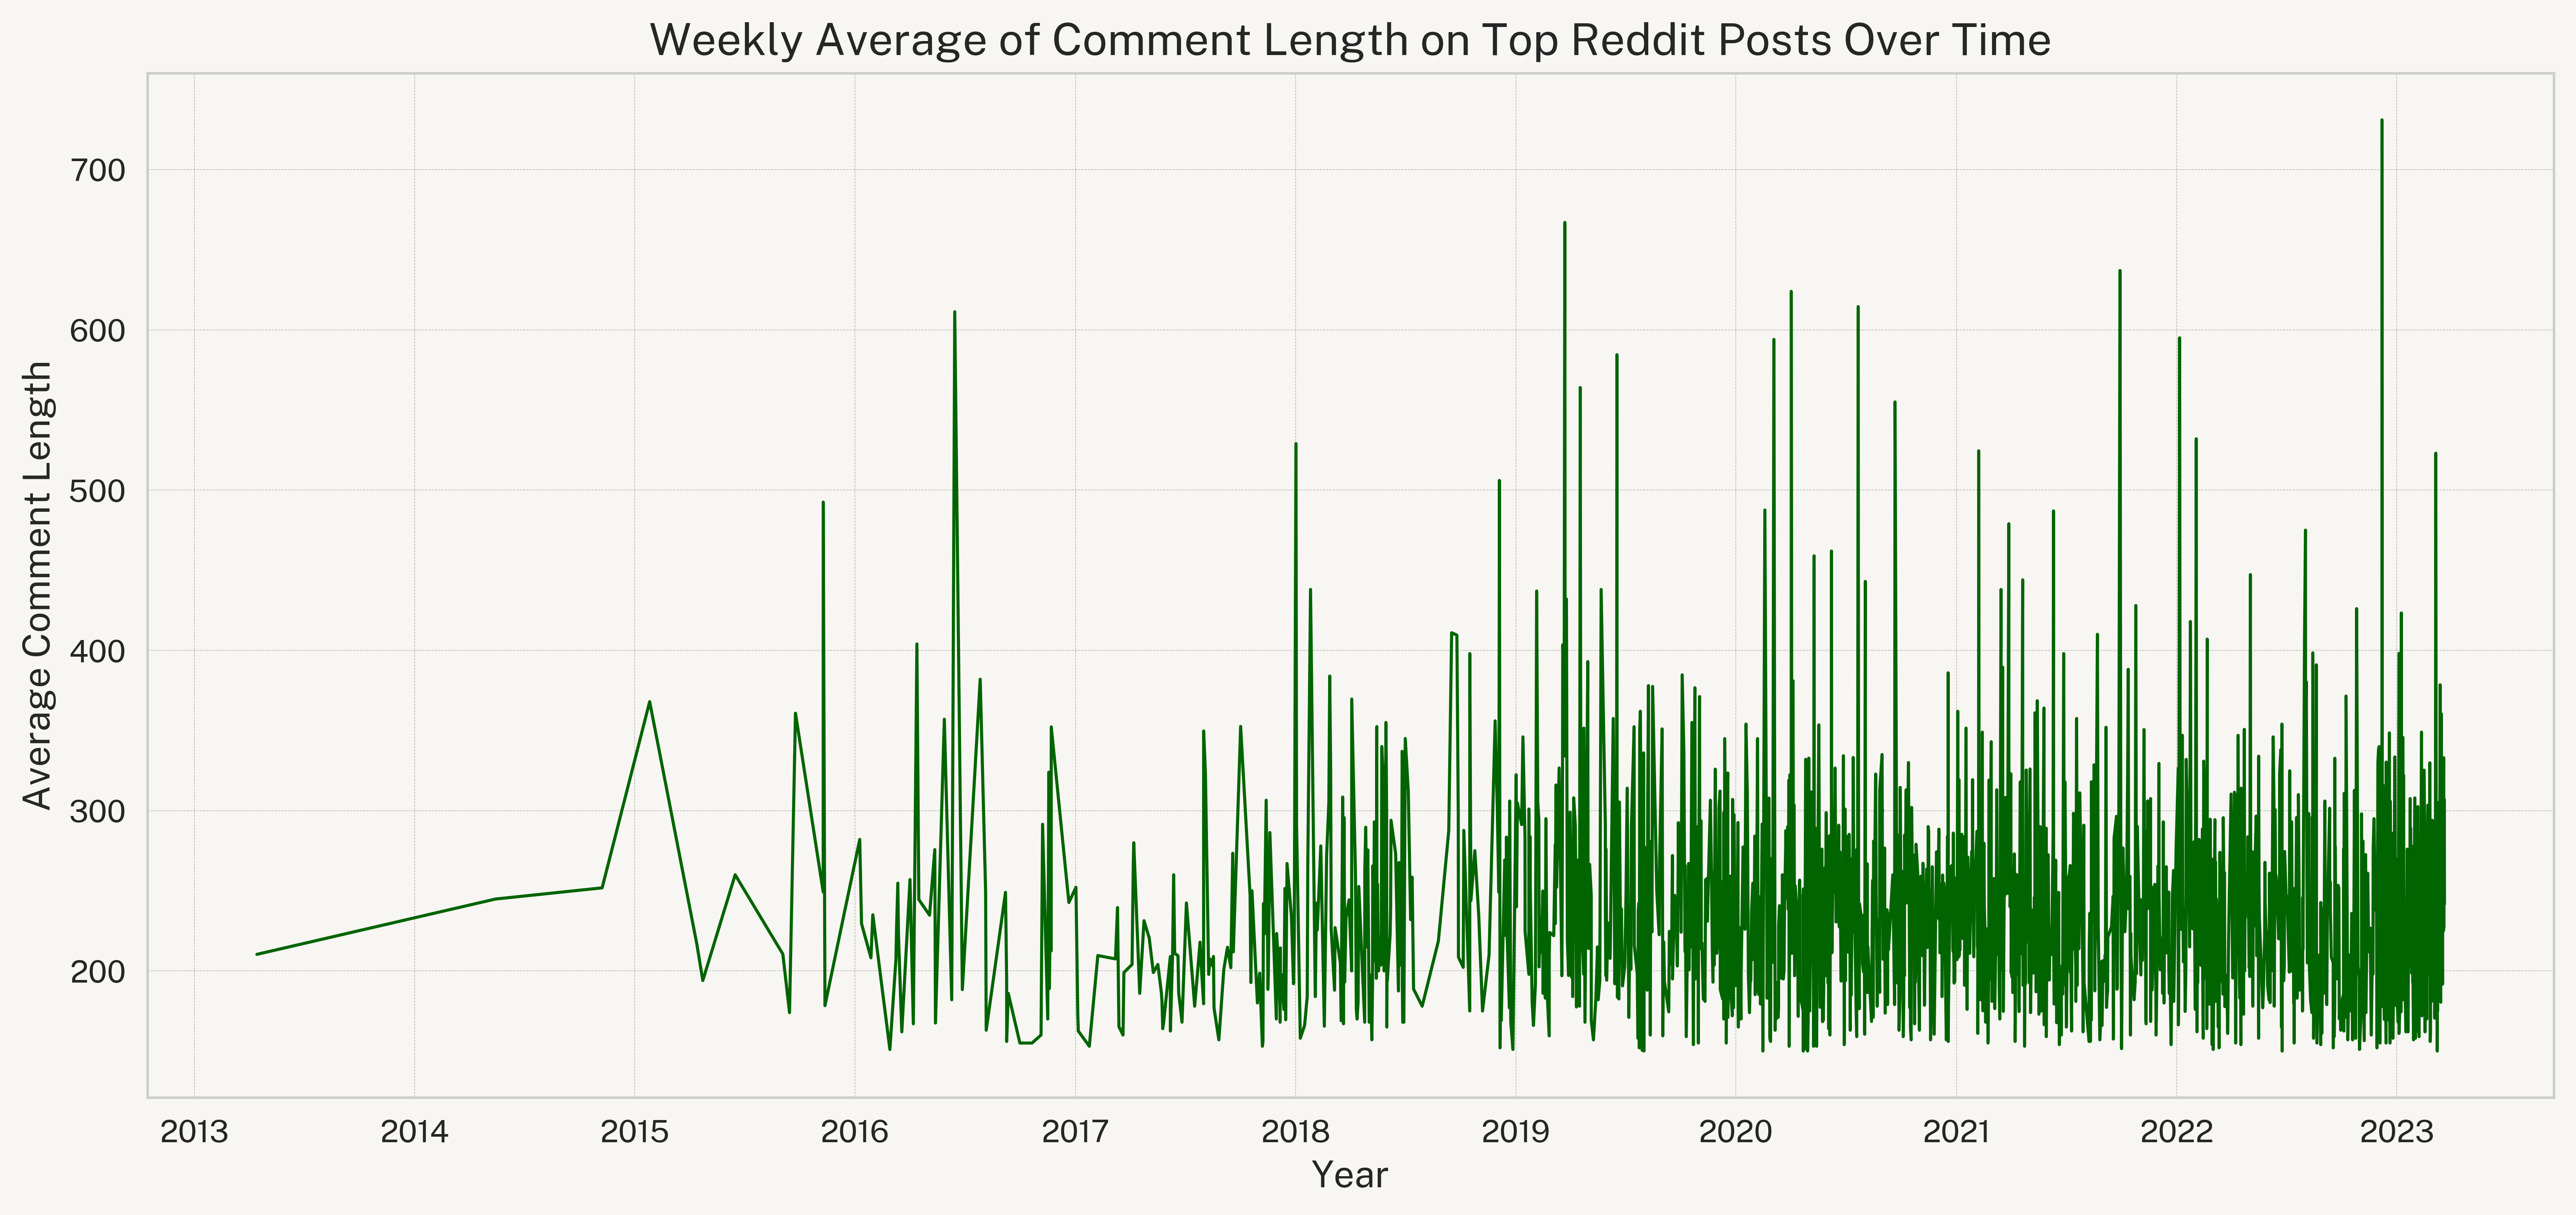

In [33]:
# plotting comment length over time, week by week
sns.lineplot(data=top_posts, x='date-time', y='avg_comment_length', color='darkgreen', linewidth=1)
plt.title('Weekly Average of Comment Length on Top Reddit Posts Over Time')
plt.xlabel('Year')
plt.ylabel('Average Comment Length')

plt.show()

In [34]:
weekly_time_series = top_posts.groupby(['year', 'week']).agg({ 'avg_comment_length': 'mean', 'avg_comment_ttr': 'mean', 'avg_comment_fkgl': 'mean' }).reset_index()

In [35]:
# construct year-week timestamp using year and week columns
weekly_time_series['date-time'] = weekly_time_series['year'].astype(str) + '-W' + weekly_time_series['week'].astype(str) + '-1'
weekly_time_series['date-time'] = pd.to_datetime(weekly_time_series['date-time'], format='%G-W%V-%u')
weekly_time_series = weekly_time_series.set_index('date-time')

weekly_time_series.head()

year  week  avg_comment_length  avg_comment_ttr  avg_comment_fkgl
date-time                                                                    
2013-04-08  2013    15          210.333333         0.567902          8.366667
2014-05-12  2014    20          244.852941         0.563459          9.964706
2014-11-03  2014    45          251.827586         0.570998         11.186207
2015-01-19  2015     4          368.000000         0.521757          9.540000
2015-04-13  2015    16          216.666667         0.575216          9.570370

### Trimming sparse data

In [36]:
# Keep data only from Jan 2015 to Dec 2022

weekly_time_series = weekly_time_series.loc['2016-01-01':'2022-12-31']

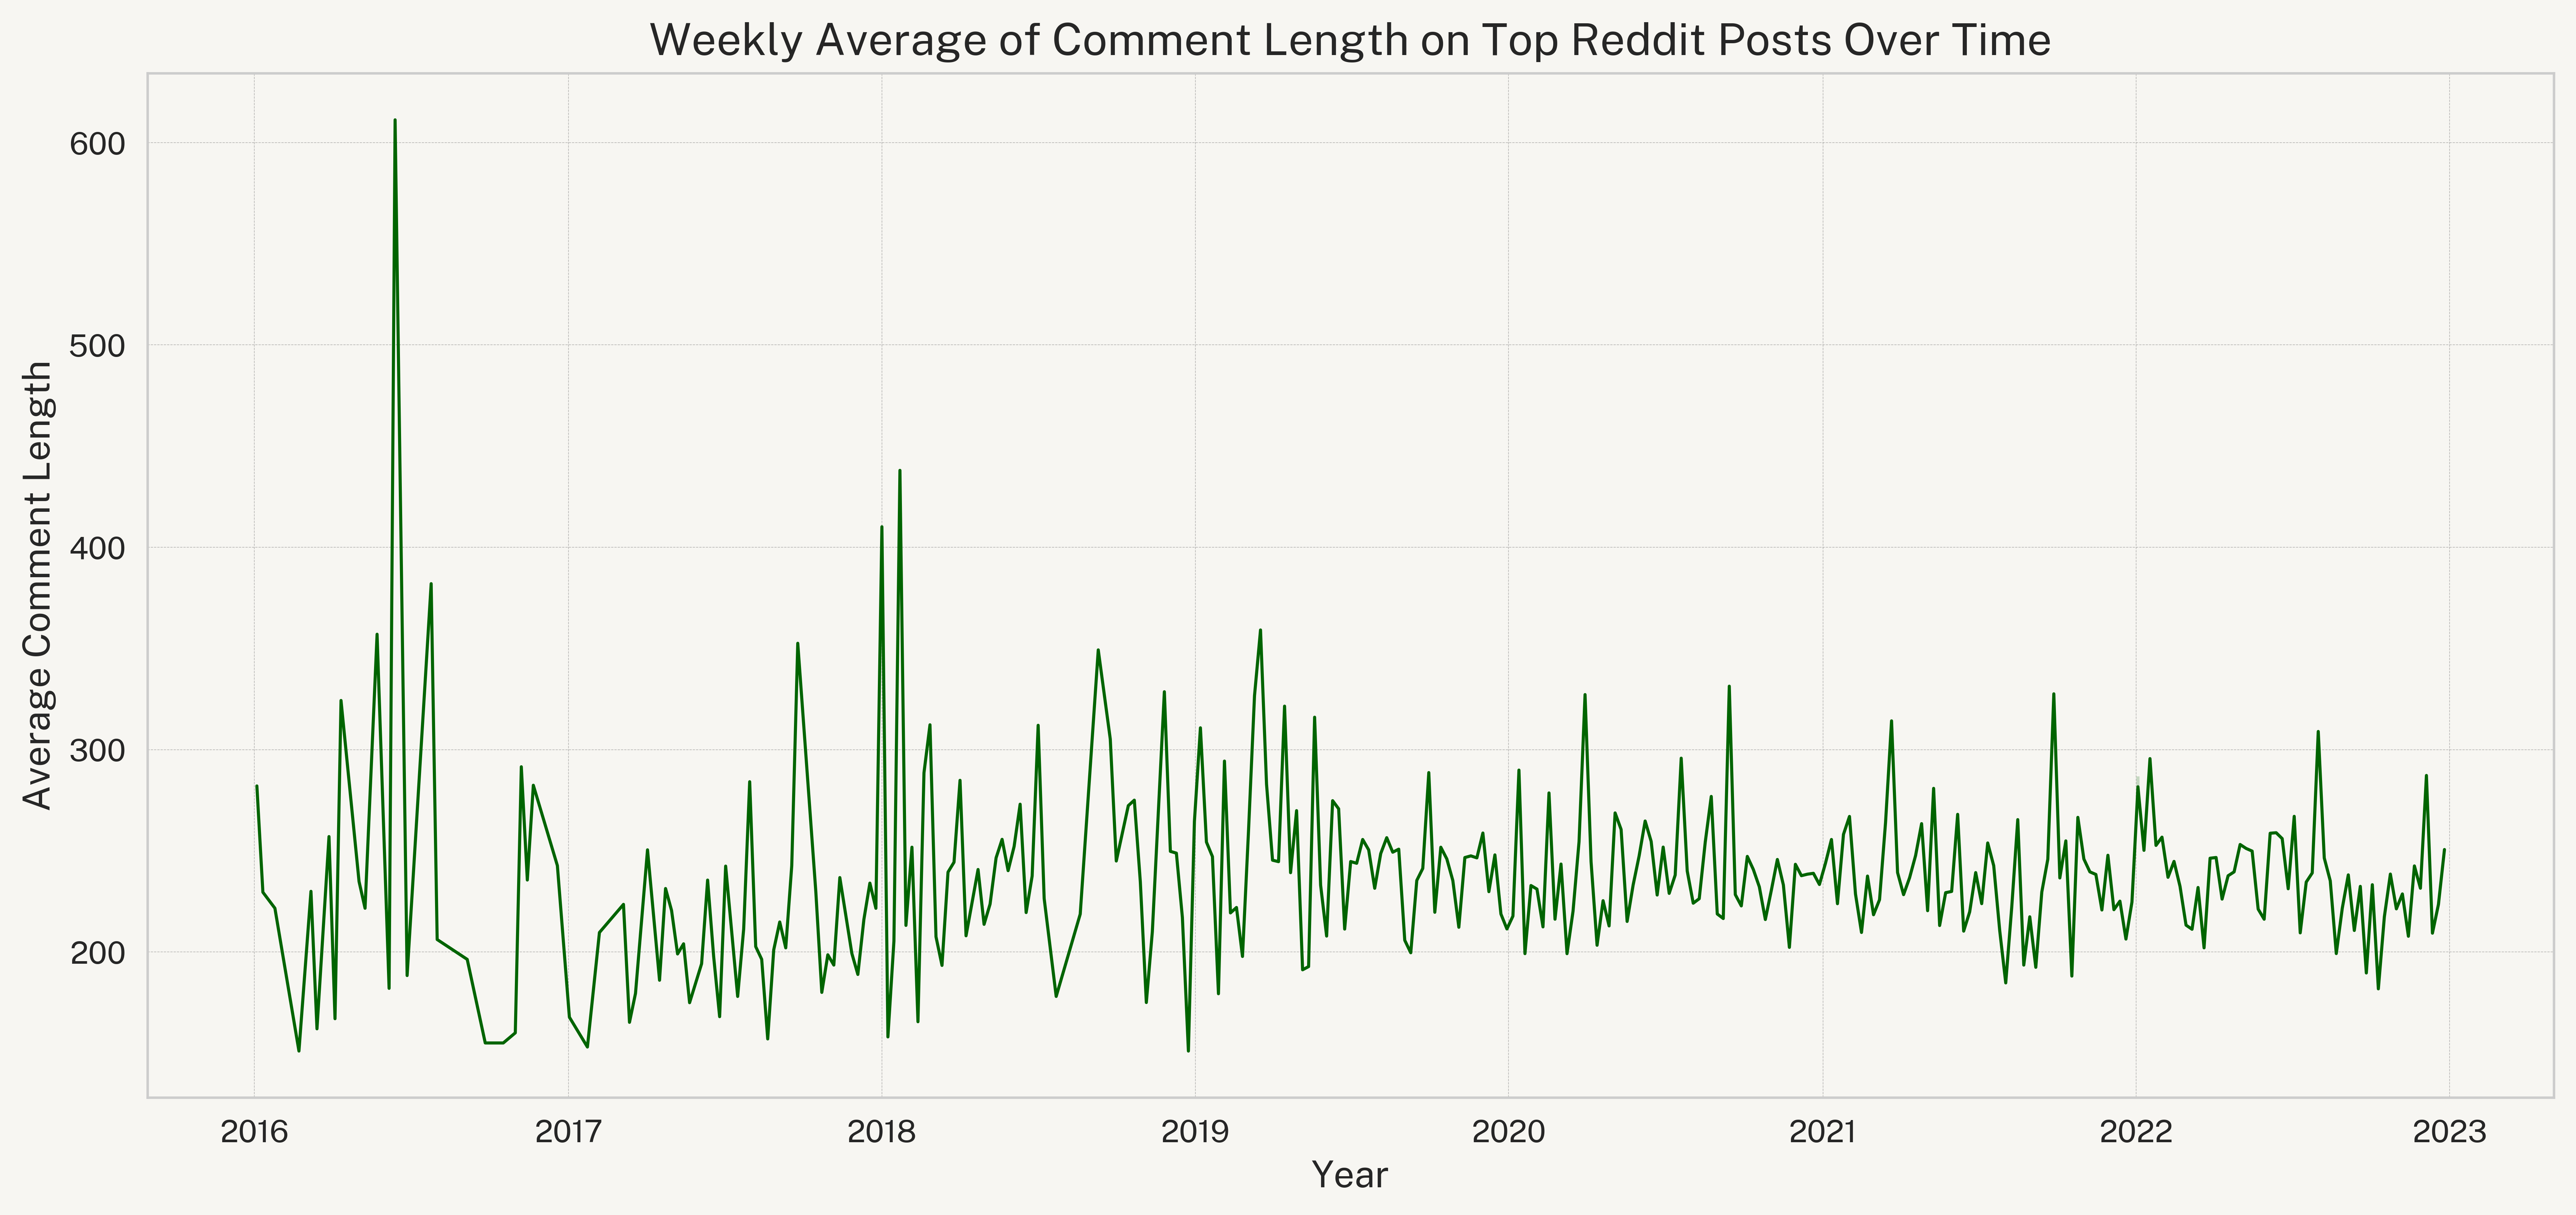

In [37]:
# plotting comment length over time, week by week
sns.lineplot(data=weekly_time_series, x='date-time', y='avg_comment_length', color='darkgreen', linewidth=1)
plt.title('Weekly Average of Comment Length on Top Reddit Posts Over Time')
plt.xlabel('Year')
plt.ylabel('Average Comment Length')

plt.show()

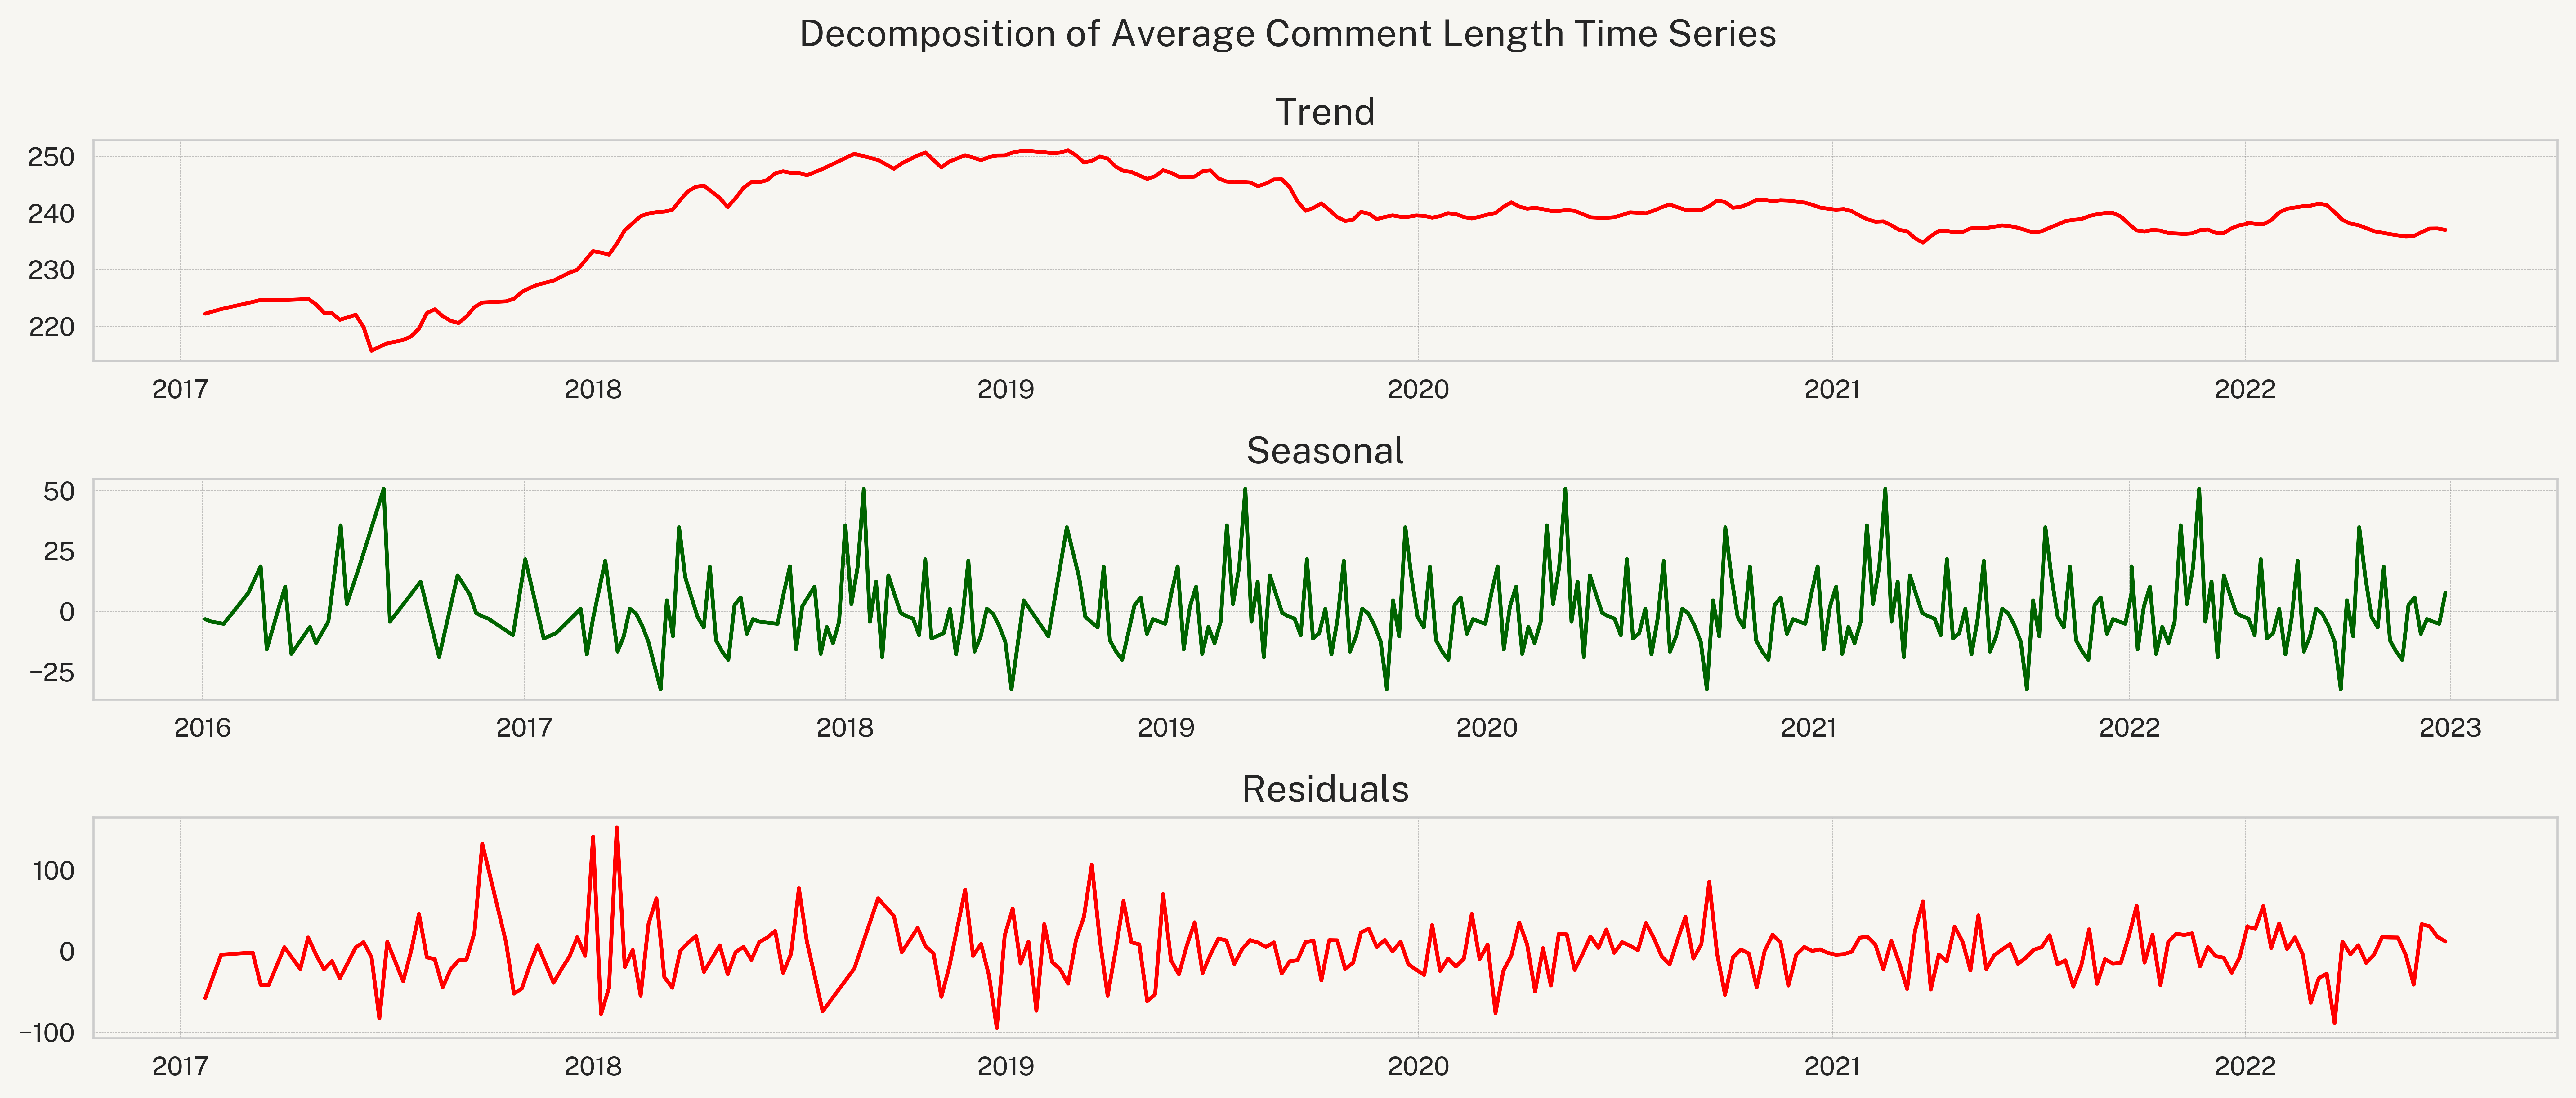

In [38]:
# decomposing weekly time series into trend, seasonality and residuals

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(weekly_time_series['avg_comment_length'], model='additive', period=52)

fig, axes = plt.subplots(3, 1)
fig.suptitle('Decomposition of Average Comment Length Time Series')

axes[0].plot(decomposition.trend, color='red')
axes[0].set_title('Trend')
axes[1].plot(decomposition.seasonal, color='darkgreen')
axes[1].set_title('Seasonal')
axes[2].plot(decomposition.resid, color='red')
axes[2].set_title('Residuals')

plt.tight_layout()
plt.show()

### Removing any trends and seasonality

In [39]:
first_diff = weekly_time_series['avg_comment_length'].diff().dropna()

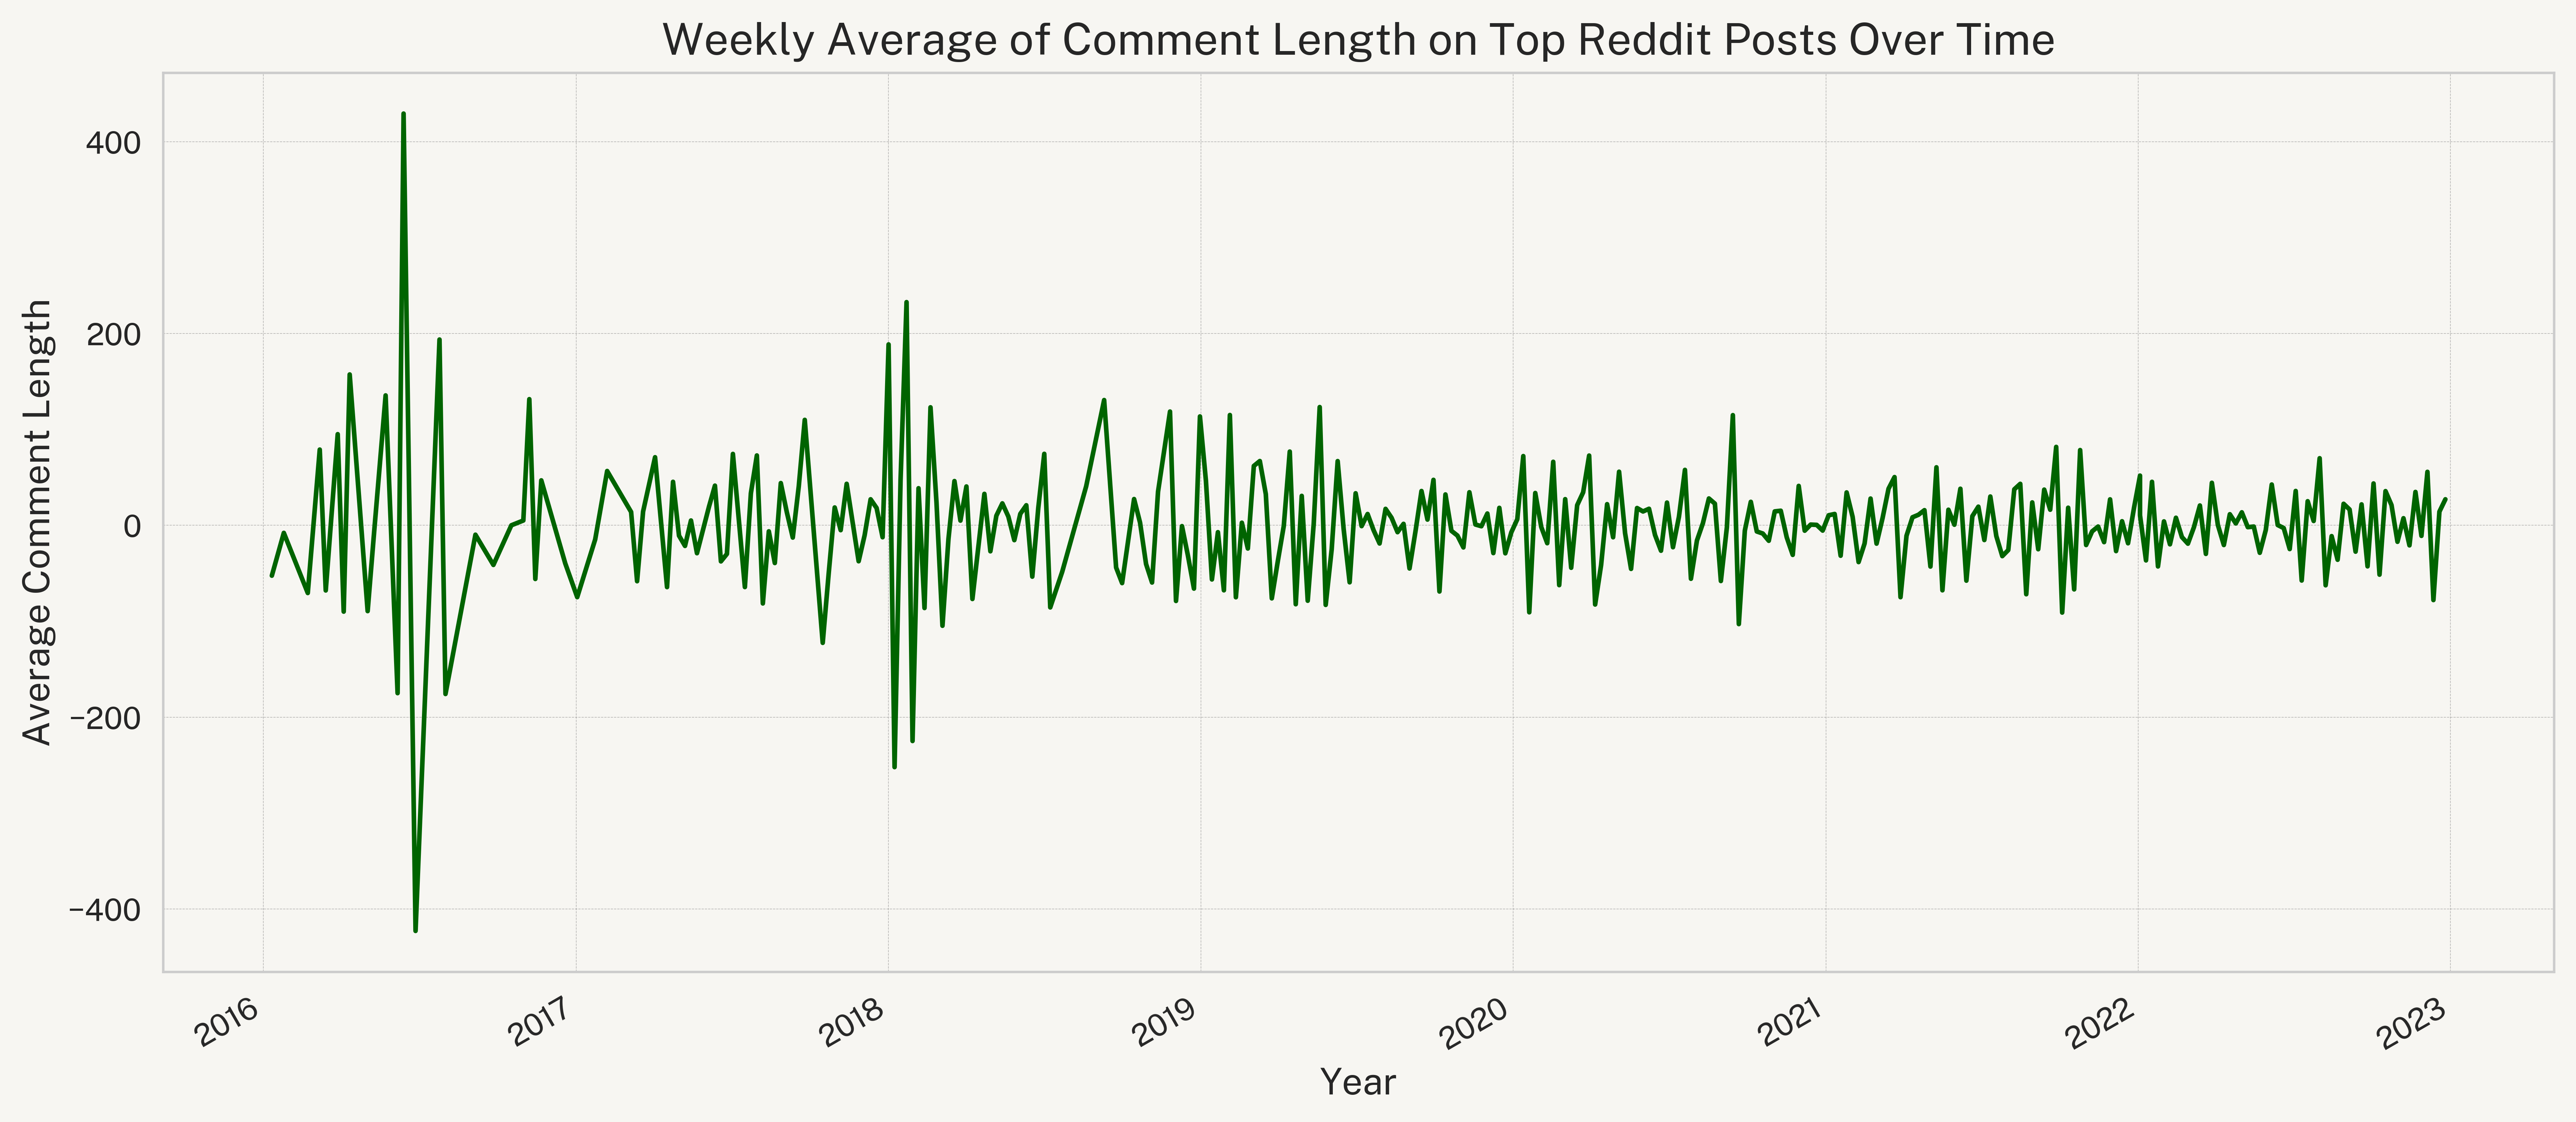

In [40]:
# plotting comment length over time, week by week
first_diff.plot(color='darkgreen')
plt.title('Weekly Average of Comment Length on Top Reddit Posts Over Time')
plt.xlabel('Year')
plt.ylabel('Average Comment Length')

plt.show()

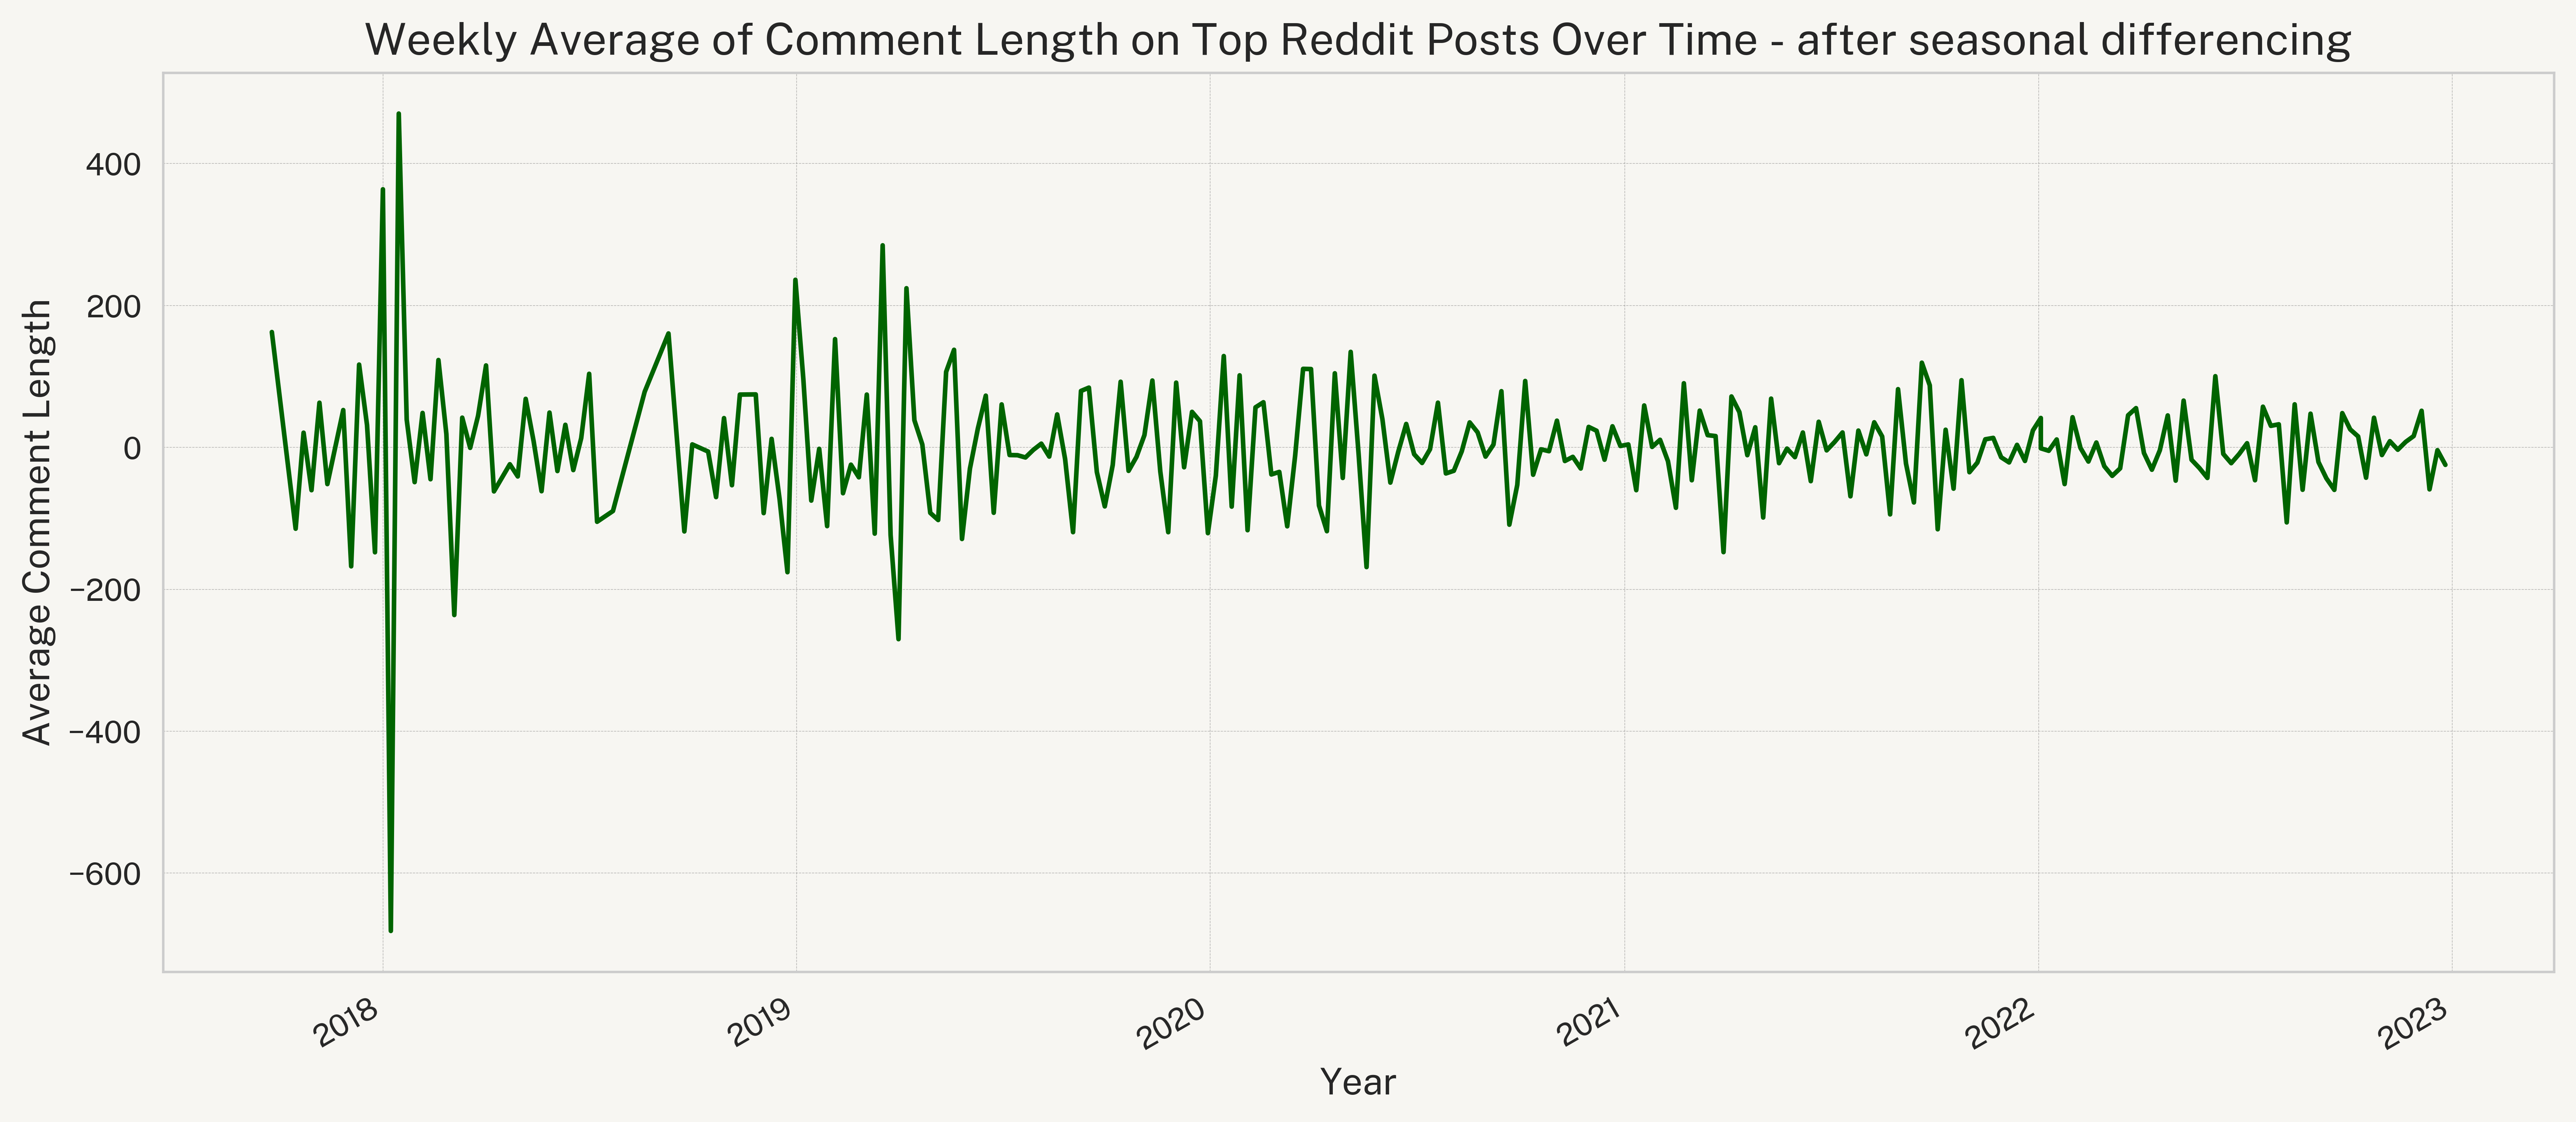

In [41]:
seasonal_diff = first_diff.diff(52).dropna()

# plotting comment length over time, week by week
seasonal_diff.plot(color='darkgreen')
plt.title('Weekly Average of Comment Length on Top Reddit Posts Over Time - after seasonal differencing')
plt.xlabel('Year')
plt.ylabel('Average Comment Length')

plt.show()

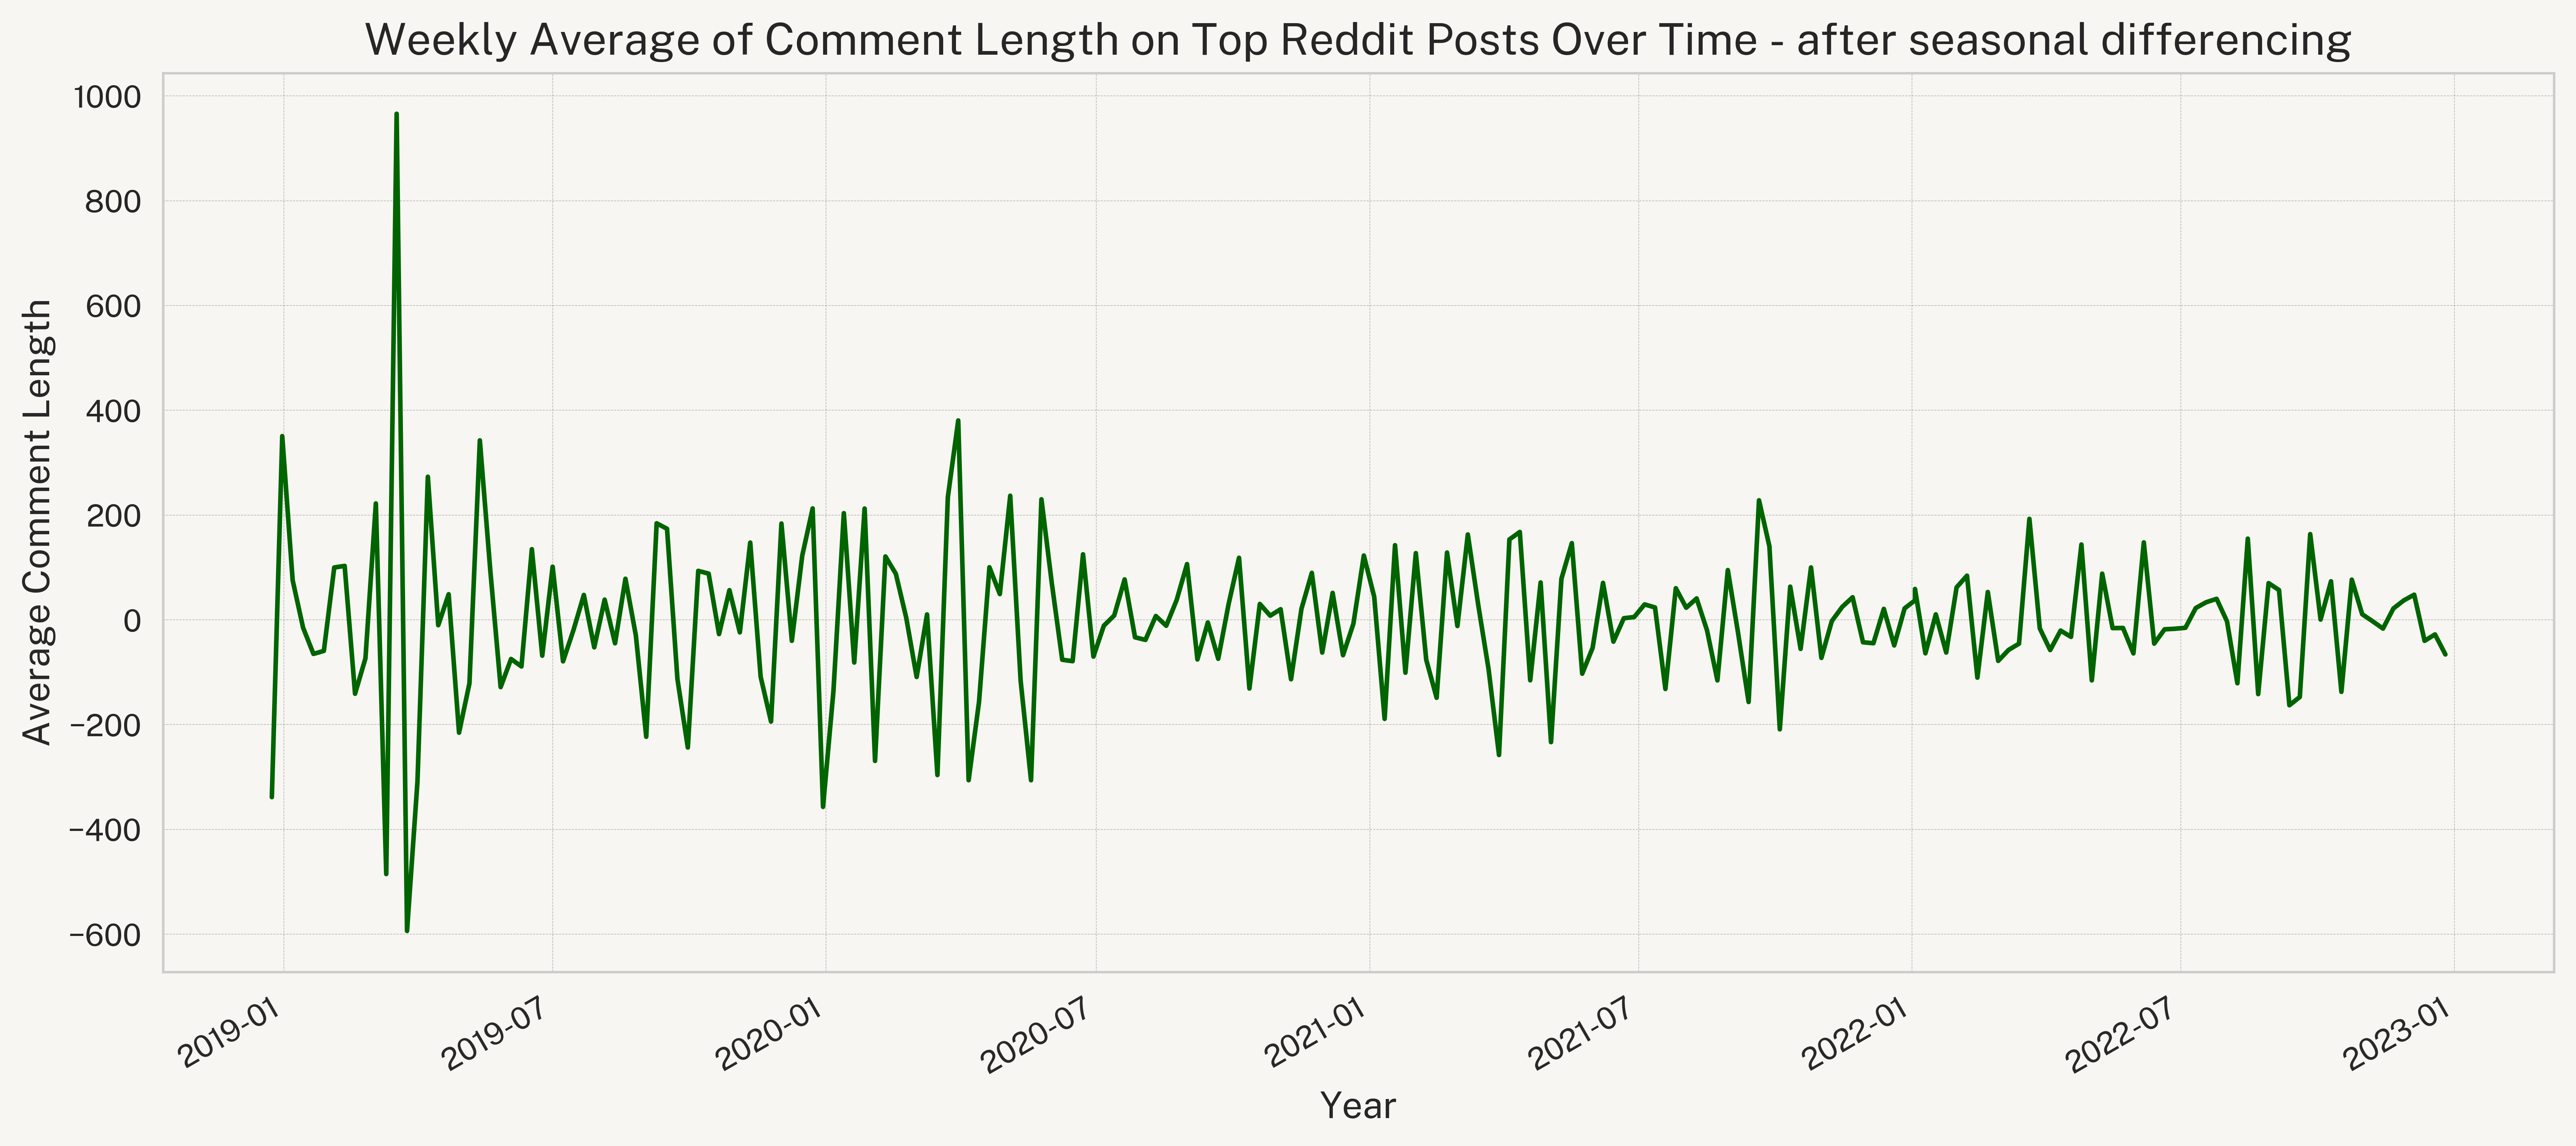

In [42]:
seasonal_diff = seasonal_diff.diff(52).dropna()

# plotting comment length over time, week by week
seasonal_diff.plot(color='darkgreen')
plt.title('Weekly Average of Comment Length on Top Reddit Posts Over Time - after seasonal differencing')
plt.xlabel('Year')
plt.ylabel('Average Comment Length')

plt.show()

## Testing for stationarity

In [43]:
# ADF test for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(seasonal_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.980692
p-value: 0.000000


Based on the above test statistic, the time series is likely stationary as it is, and requires no transformation or processing to make it stationary. We can also confirm this using the ACF and PACF.

### ACF and PACF plots

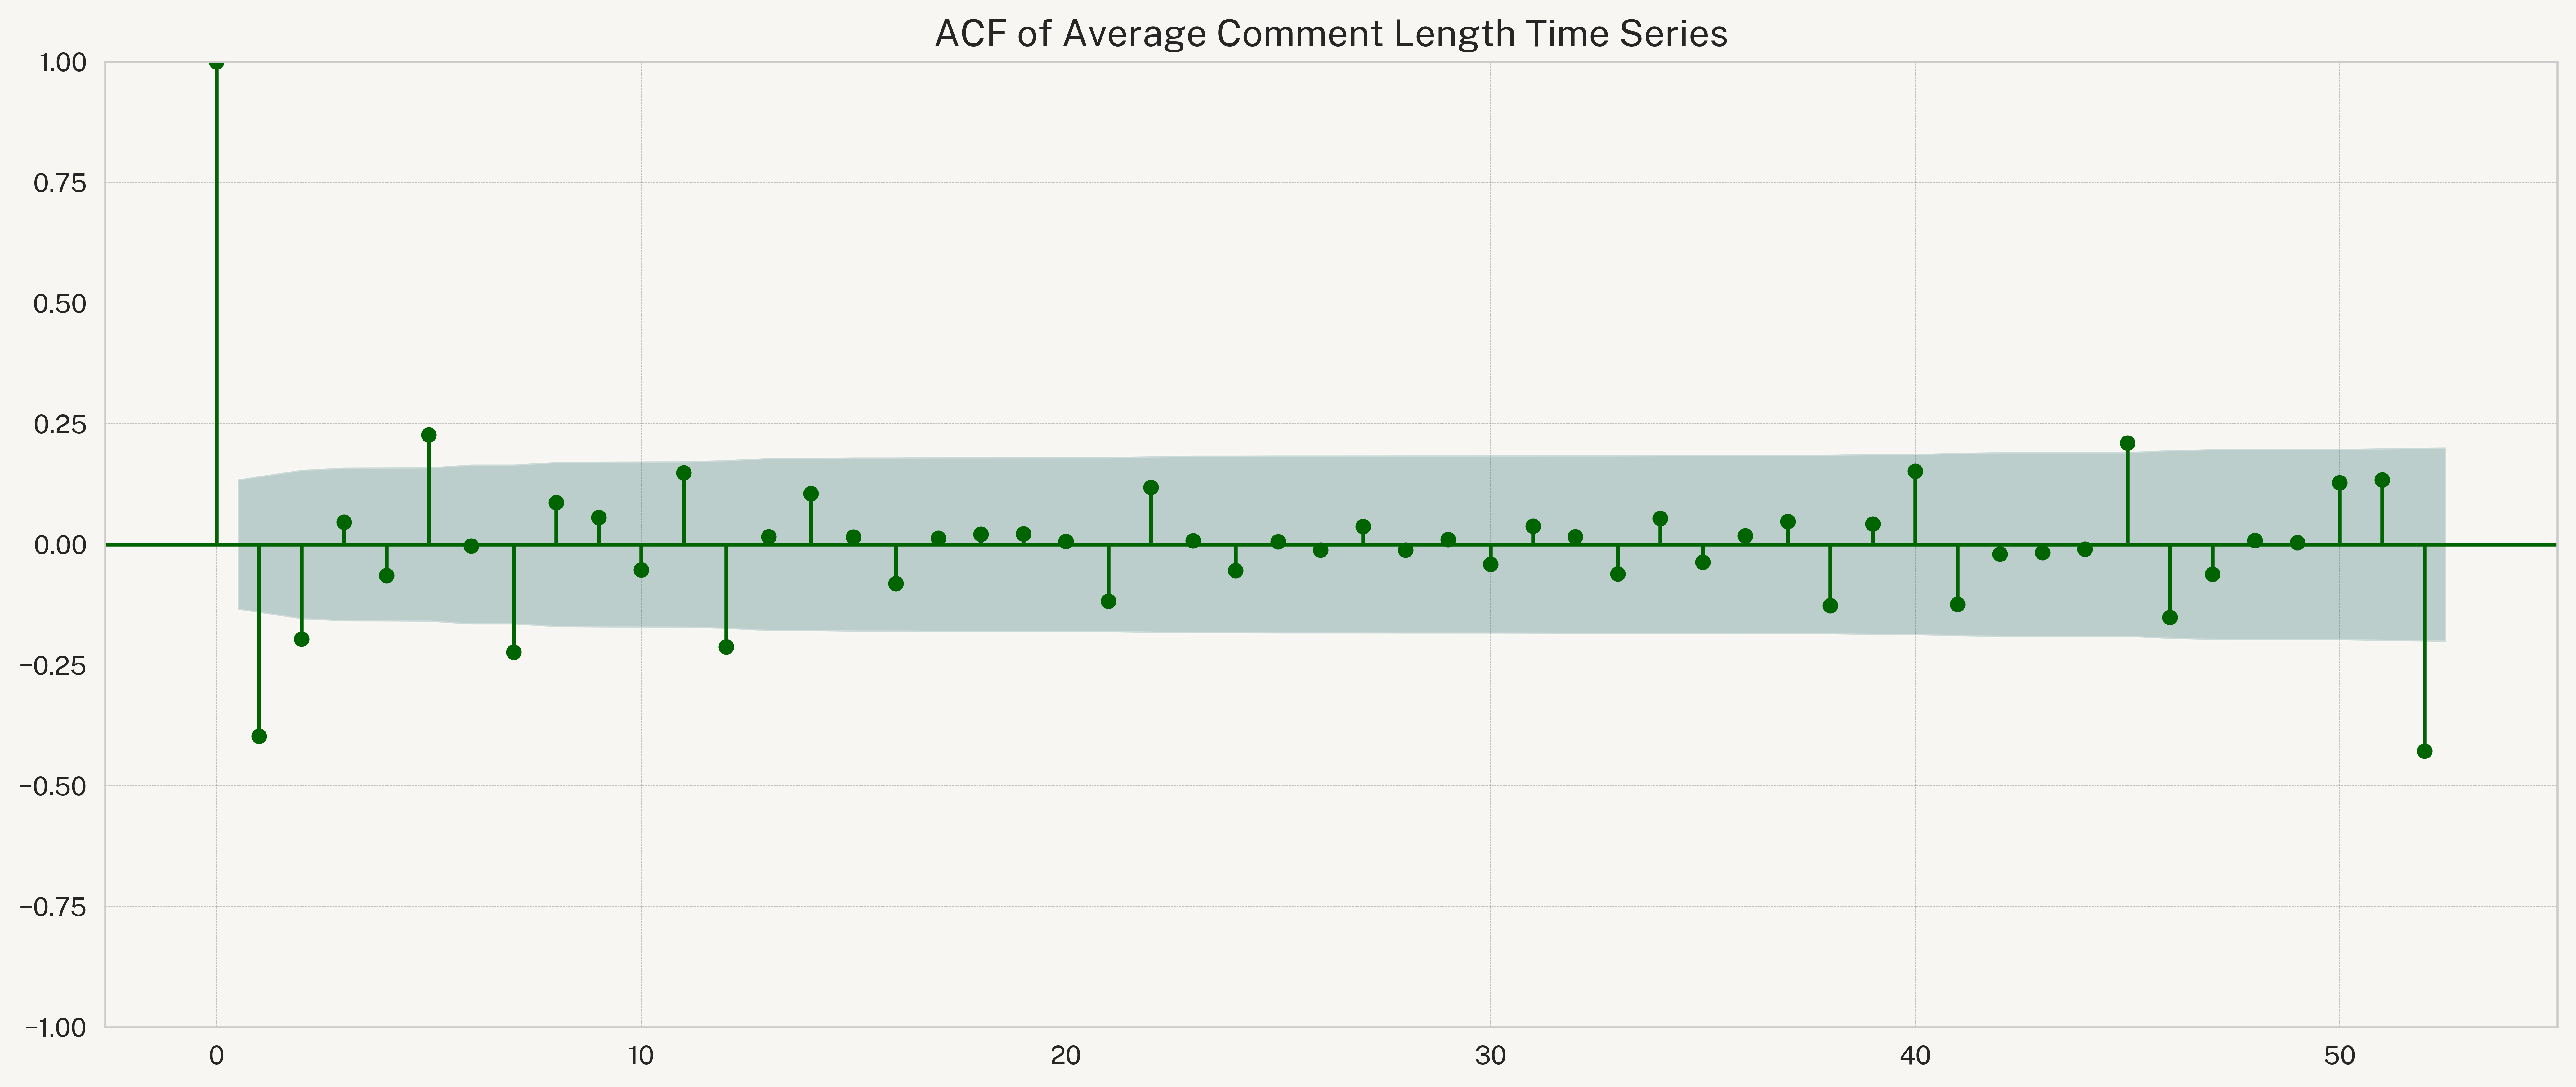

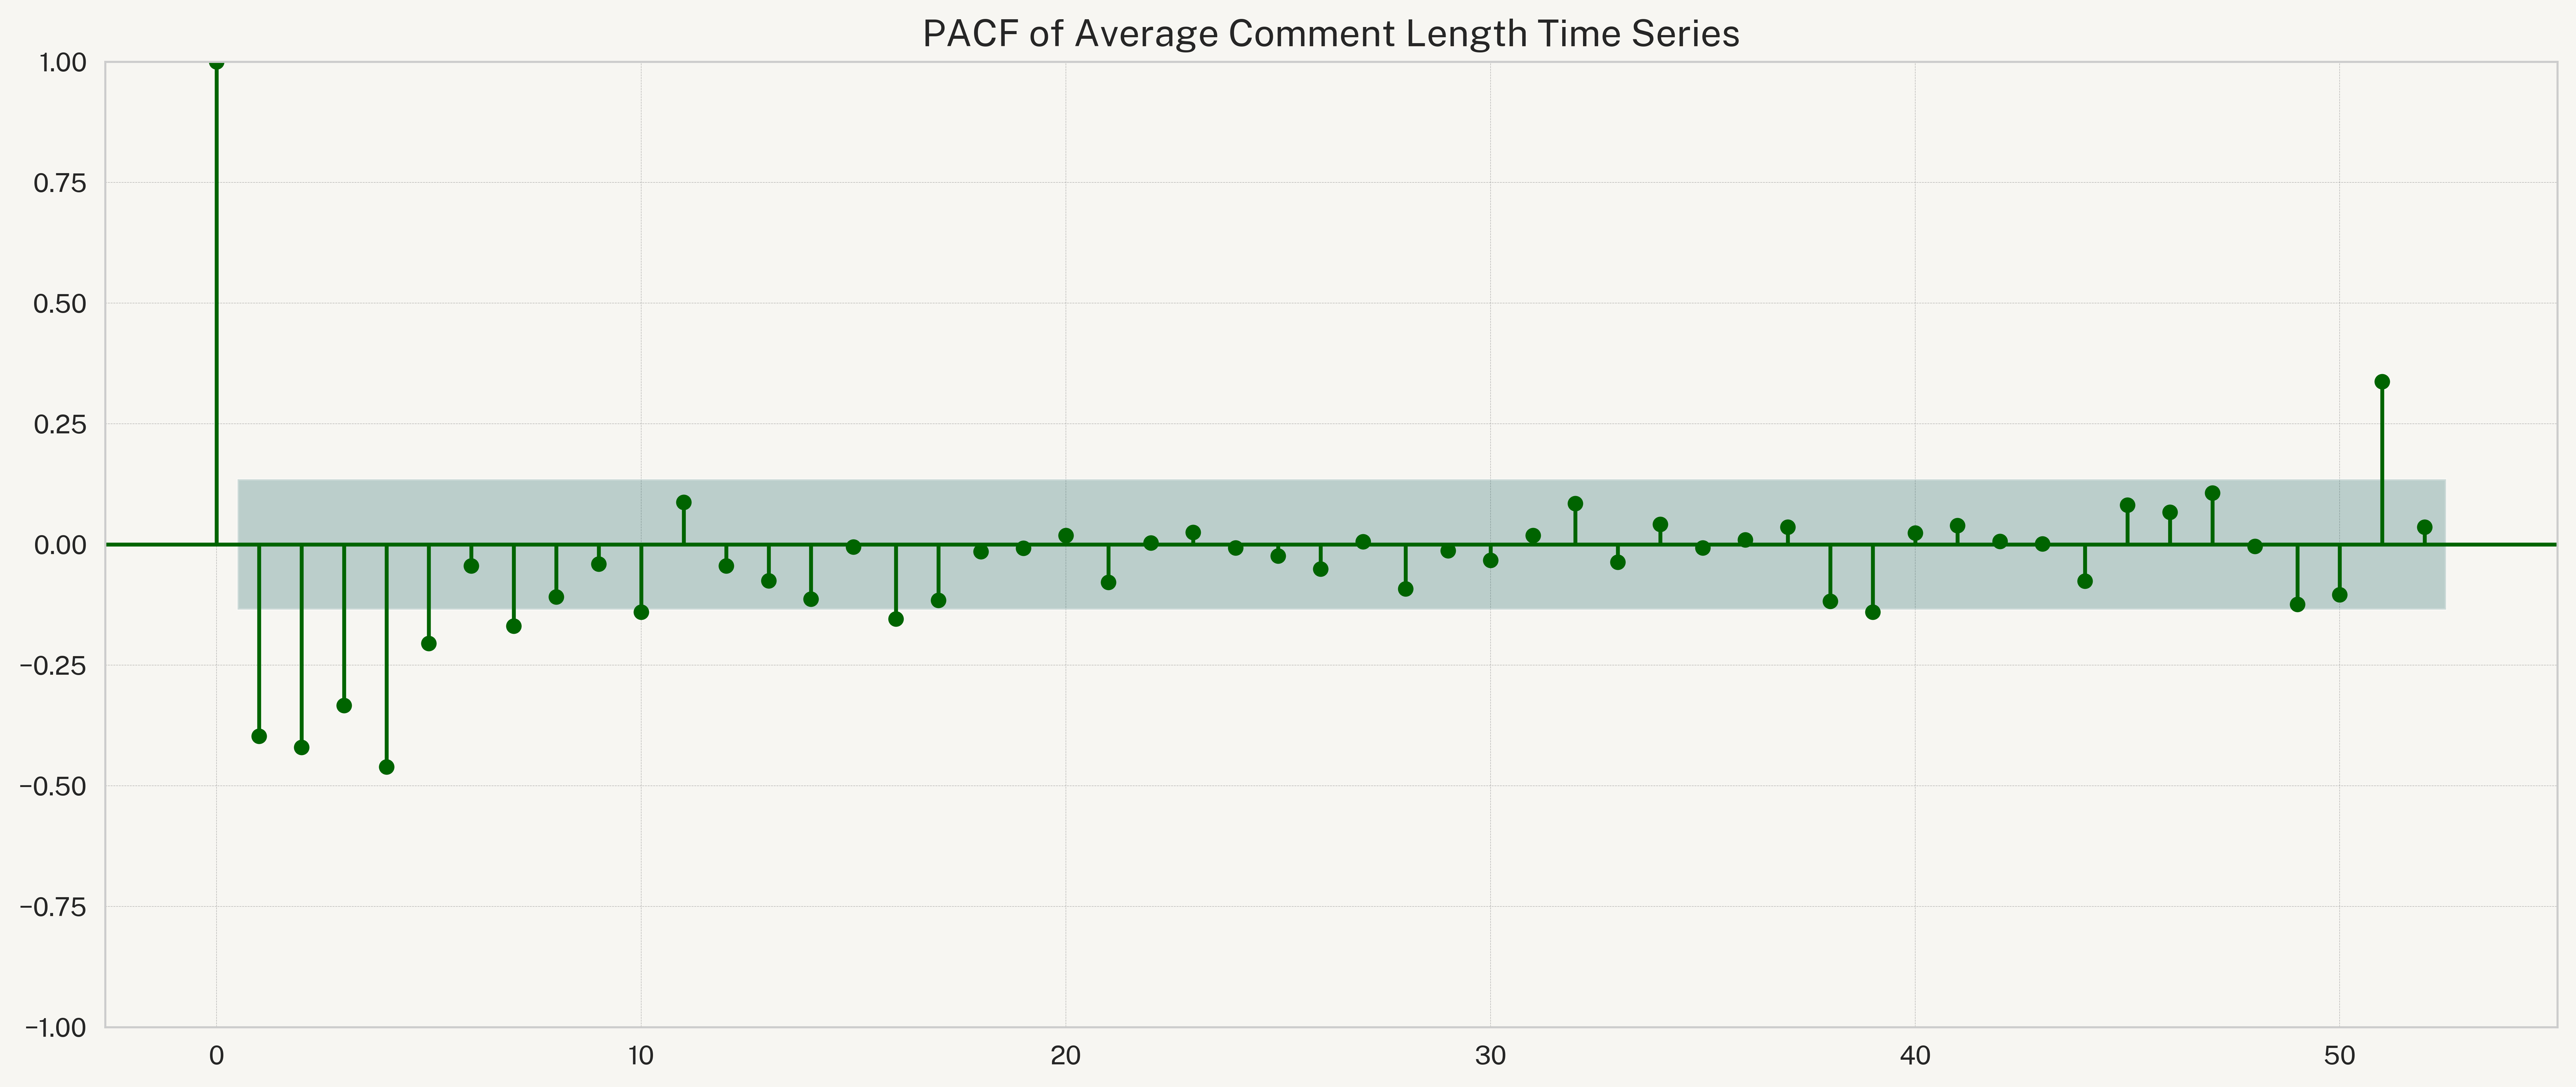

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(seasonal_diff,
        lags=52,
        color='darkgreen',
        vlines_kwargs={'color': 'darkgreen'},
        title='ACF of Average Comment Length Time Series')
plt.tight_layout()
plt.show()

plot_pacf(seasonal_diff,
    lags=52,
    color='darkgreen',
    vlines_kwargs={'color': 'darkgreen'},)
plt.title('PACF of Average Comment Length Time Series')
plt.tight_layout()
plt.show()

Looking at the ACF and PACF, we can use parameters (1, 1, 0) and (1, 2, 0, 52).

In [45]:
# splitting the time series into training and testing sets
train = weekly_time_series[weekly_time_series.index < '2021-12-31']
test = weekly_time_series[weekly_time_series.index >= '2022-01-01']

In [46]:
train.index = train.index.to_period('W')
test.index = test.index.to_period('W')

In [47]:
train.index.freq

<Week: weekday=6>

In [48]:
# Fitting a SARIMA model to the weekly time series

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['avg_comment_length'], order=(1, 1, 0), seasonal_order=(1, 2, 0, 52))
model_fit = model.fit()

In [50]:
test

year  week  avg_comment_length  avg_comment_ttr  \
date-time                                                                
2022-01-03/2022-01-09  2021    53          276.400000         0.564111   
2022-01-03/2022-01-09  2022     1          286.797129         0.566291   
2022-01-10/2022-01-16  2022     2          250.207143         0.575536   
2022-01-17/2022-01-23  2022     3          295.533333         0.537571   
2022-01-24/2022-01-30  2022     4          252.647712         0.568716   
2022-01-31/2022-02-06  2022     5          256.719780         0.550910   
2022-02-07/2022-02-13  2022     6          236.879152         0.560432   
2022-02-14/2022-02-20  2022     7          244.728890         0.568205   
2022-02-21/2022-02-27  2022     8          232.396384         0.569863   
2022-02-28/2022-03-06  2022     9          213.238095         0.573397   
2022-03-07/2022-03-13  2022    10          211.188889         0.590301   
2022-03-14/2022-03-20  2022    11          231.837500         0.565548   
2022-03-21/2022-03-27  2022    12          202.016667         0.574444   
2022-03-28/2022-04-03  2022    13          246.311111         0.579354   
2022-04-04/2022-04-10  2022    14          246.659524         0.546658   
2022-04-11/2022-04-17  2022    15          226.105107         0.556687   
2022-04-18/2022-04-24  2022    16          237.636797         0.570115   
2022-04-25/2022-05-01  2022    17          239.561224         0.576402   
2022-05-02/2022-05-08  2022    18          253.092366         0.565076   
2022-05-09/2022-05-15  2022    19          251.138776         0.568891   
2022-05-16/2022-05-22  2022    20          249.833333         0.589076   
2022-05-23/2022-05-29  2022    21          221.162865         0.586037   
2022-05-30/2022-06-05  2022    22          216.159524         0.571923   
2022-06-06/2022-06-12  2022    23          258.658333         0.528598   
2022-06-13/2022-06-19  2022    24          258.903610         0.561949   
2022-06-20/2022-06-26  2022    25          256.002183         0.577658   
2022-06-27/2022-07-03  2022    26          231.219444         0.540164   
2022-07-04/2022-07-10  2022    27          267.004167         0.554667   
2022-07-11/2022-07-17  2022    28          209.424167         0.561273   
2022-07-18/2022-07-24  2022    29          234.523810         0.553938   
2022-07-25/2022-07-31  2022    30          239.027778         0.539268   
2022-08-01/2022-08-07  2022    31          308.947619         0.537856   
2022-08-08/2022-08-14  2022    32          246.415100         0.563622   
2022-08-15/2022-08-21  2022    33          235.114583         0.559479   
2022-08-22/2022-08-28  2022    34          199.194444         0.603610   
2022-08-29/2022-09-04  2022    35          221.616465         0.577286   
2022-09-05/2022-09-11  2022    36          238.075000         0.576780   
2022-09-12/2022-09-18  2022    37          210.603704         0.546236   
2022-09-19/2022-09-25  2022    38          232.390079         0.569183   
2022-09-26/2022-10-02  2022    39          189.600000         0.586414   
2022-10-03/2022-10-09  2022    40          233.207071         0.565830   
2022-10-10/2022-10-16  2022    41          181.750000         0.621020   
2022-10-17/2022-10-23  2022    42          217.374820         0.588485   
2022-10-24/2022-10-30  2022    43          238.476190         0.559141   
2022-10-31/2022-11-06  2022    44          221.285714         0.534932   
2022-11-07/2022-11-13  2022    45          228.649490         0.577511   
2022-11-14/2022-11-20  2022    46          207.742857         0.578747   
2022-11-21/2022-11-27  2022    47          242.500000         0.534905   
2022-11-28/2022-12-04  2022    48          231.476852         0.570769   
2022-12-05/2022-12-11  2022    49          287.205983         0.510237   
2022-12-12/2022-12-18  2022    50          209.265422         0.570181   
2022-12-19/2022-12-25  2022    51          223.477857         0.550937   
2022-12-26/2023-01-01  2022

In [51]:
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

In [52]:
# testing model performance
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(test['avg_comment_length'], forecast)

In [53]:
rmse

54.48811729466289

In [54]:
# convert Period index to datetime index for plotting
# test.index = test.index.to_timestamp()
# forecast.index = forecast.index.to_timestamp()

# plot test and forecasted values
plt.plot(test['avg_comment_length'], color='black')
plt.plot(forecast, color='red')
plt.title('SARIMA Forecast of Average Comment Length on Top Reddit Posts')
plt.xlabel('Year')
plt.ylabel('Average Comment Length')
plt.legend(['Test', 'Forecast'])
plt.tight_layout()
plt.show()

TypeError: float() argument must be a string or a real number, not 'Period'